In [4]:
import pandas as pd
full_data = pd.read_csv('weatherAUS.csv')
full_data.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,0.0,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,0.0,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,0.0,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,1.0,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,0.2,No


In [5]:
full_data['RainToday'].replace({'No': 0, 'Yes': 1},inplace = True)
full_data['RainTomorrow'].replace({'No': 0, 'Yes': 1},inplace = True)

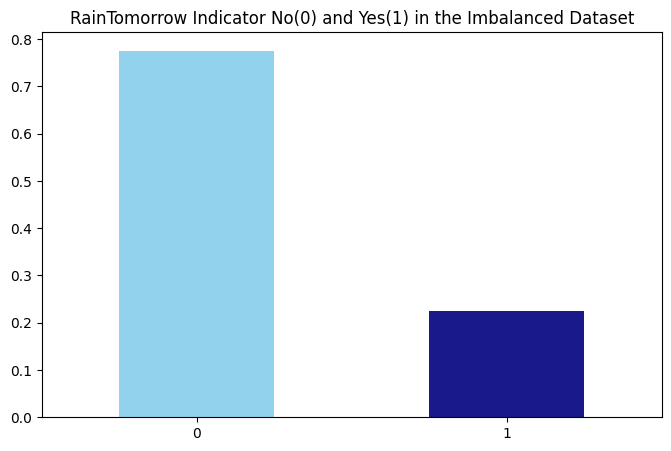

In [6]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (8,5))
full_data.RainTomorrow.value_counts(normalize = True).plot(kind='bar', color= ['skyblue','navy'], alpha = 0.9, rot=0)
plt.title('RainTomorrow Indicator No(0) and Yes(1) in the Imbalanced Dataset')
plt.show()

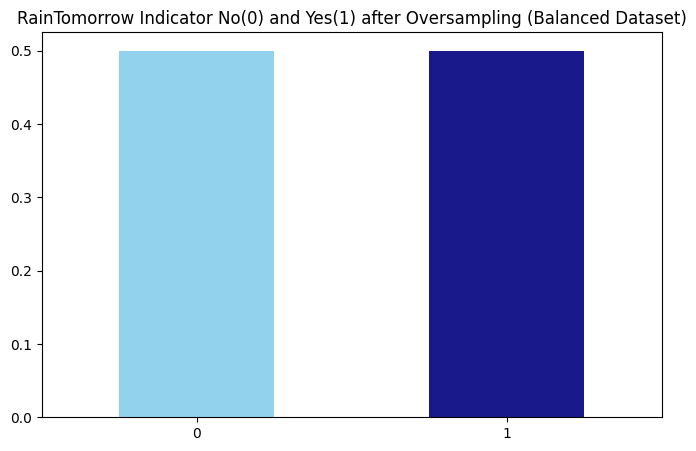

In [7]:
from sklearn.utils import resample

no = full_data[full_data.RainTomorrow == 0]
yes = full_data[full_data.RainTomorrow == 1]
yes_oversampled = resample(yes, replace=True, n_samples=len(no), random_state=123)
oversampled = pd.concat([no, yes_oversampled])

fig = plt.figure(figsize = (8,5))
oversampled.RainTomorrow.value_counts(normalize = True).plot(kind='bar', color= ['skyblue','navy'], alpha = 0.9, rot=0)
plt.title('RainTomorrow Indicator No(0) and Yes(1) after Oversampling (Balanced Dataset)')
plt.show()

<AxesSubplot: >

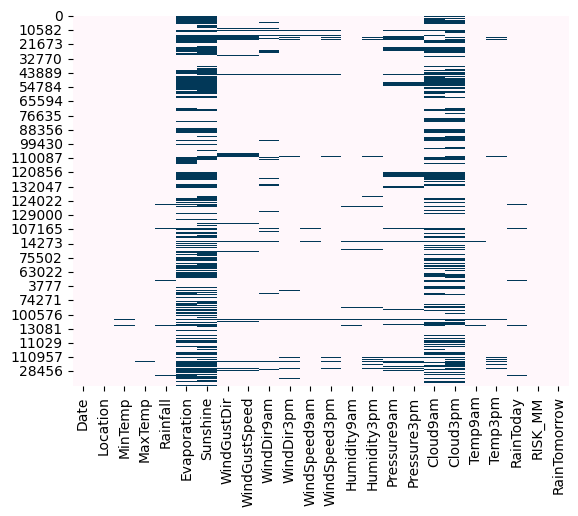

In [8]:
# Missing Data Pattern in Training Data
import seaborn as sns
sns.heatmap(oversampled.isnull(), cbar=False, cmap='PuBu')

In [9]:
total = oversampled.isnull().sum().sort_values(ascending=False)
percent = (oversampled.isnull().sum()/oversampled.isnull().count()).sort_values(ascending=False)
missing = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing.head(4)

,Total,Percent
Sunshine,104831,0.475140
Evaporation,95411,0.432444
Cloud3pm,85614,0.388040
Cloud9am,81339,0.368664


In [10]:
oversampled.select_dtypes(include=['object']).columns

Index(['Date', 'Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm'], dtype='object')

In [11]:
# Impute categorical var with Mode
oversampled['Date'] = oversampled['Date'].fillna(oversampled['Date'].mode()[0])
oversampled['Location'] = oversampled['Location'].fillna(oversampled['Location'].mode()[0])
oversampled['WindGustDir'] = oversampled['WindGustDir'].fillna(oversampled['WindGustDir'].mode()[0])
oversampled['WindDir9am'] = oversampled['WindDir9am'].fillna(oversampled['WindDir9am'].mode()[0])
oversampled['WindDir3pm'] = oversampled['WindDir3pm'].fillna(oversampled['WindDir3pm'].mode()[0])

In [12]:
# Convert categorical features to continuous features with Label Encoding
from sklearn.preprocessing import LabelEncoder
lencoders = {}
for col in oversampled.select_dtypes(include=['object']).columns:
    lencoders[col] = LabelEncoder()
    oversampled[col] = lencoders[col].fit_transform(oversampled[col])

In [13]:
import warnings
warnings.filterwarnings("ignore")
# Multiple Imputation by Chained Equations
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
MiceImputed = oversampled.copy(deep=True) 
mice_imputer = IterativeImputer()
MiceImputed.iloc[:, :] = mice_imputer.fit_transform(oversampled)

In [14]:
# Detecting outliers with IQR
Q1 = MiceImputed.quantile(0.25)
Q3 = MiceImputed.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

Date             1535.000000
Location           25.000000
MinTemp             9.300000
MaxTemp            10.200000
Rainfall            2.400000
Evaporation         4.119679
Sunshine            5.947404
WindGustDir         9.000000
WindGustSpeed      19.000000
WindDir9am          8.000000
WindDir3pm          8.000000
WindSpeed9am       13.000000
WindSpeed3pm       11.000000
Humidity9am        26.000000
Humidity3pm        30.000000
Pressure9am         8.800000
Pressure3pm         8.800000
Cloud9am            4.000000
Cloud3pm            3.681346
Temp9am             9.300000
Temp3pm             9.800000
RainToday           1.000000
RISK_MM             5.200000
RainTomorrow        1.000000
dtype: float64


In [15]:
# Removing outliers from the dataset
MiceImputed = MiceImputed[~((MiceImputed < (Q1 - 1.5 * IQR)) |(MiceImputed > (Q3 + 1.5 * IQR))).any(axis=1)]
MiceImputed.shape

(156852, 24)

In [16]:
# Correlation Heatmap
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
corr = MiceImputed.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
f, ax = plt.subplots(figsize=(20, 20))
cmap = sns.diverging_palette(250, 25, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=None, center=0,square=True, annot=True, linewidths=.5, cbar_kws={"shrink": .9})

AttributeError: module 'numpy' has no attribute 'bool'.
`np.bool` was a deprecated alias for the builtin `bool`. To avoid this error in existing code, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

In [ ]:
sns.pairplot( data=MiceImputed, vars=('MaxTemp','MinTemp','Pressure9am','Pressure3pm', 'Temp9am', 'Temp3pm', 'Evaporation'), hue='RainTomorrow' )


In [ ]:
# Standardizing data
from sklearn import preprocessing
r_scaler = preprocessing.MinMaxScaler()
r_scaler.fit(MiceImputed)
modified_data = pd.DataFrame(r_scaler.transform(MiceImputed), index=MiceImputed.index, columns=MiceImputed.columns)

In [ ]:
# Feature Importance using Filter Method (Chi-Square)
from sklearn.feature_selection import SelectKBest, chi2
X = modified_data.loc[:,modified_data.columns!='RainTomorrow']
y = modified_data[['RainTomorrow']]
selector = SelectKBest(chi2, k=10)
selector.fit(X, y)
X_new = selector.transform(X)
print(X.columns[selector.get_support(indices=True)])

In [ ]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier as rf

X = MiceImputed.drop('RainTomorrow', axis=1)
y = MiceImputed['RainTomorrow']
selector = SelectFromModel(rf(n_estimators=100, random_state=0))
selector.fit(X, y)
support = selector.get_support()
features = X.loc[:,support].columns.tolist()
print(features)
print(rf(n_estimators=100, random_state=0).fit(X,y).feature_importances_)

In [17]:
features = MiceImputed[['Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustDir', 
                       'WindGustSpeed', 'WindDir9am', 'WindDir3pm', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 
                       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 
                       'RainToday']]
target = MiceImputed['RainTomorrow']

# Split into test and train
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.25, random_state=12345)

# Normalize Features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [18]:
def plot_roc_cur(fper, tper):  
    plt.plot(fper, tper, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

In [21]:
import time
from sklearn.metrics import accuracy_score, roc_auc_score, cohen_kappa_score, roc_curve, classification_report
def run_model(model, X_train, y_train, X_test, y_test, verbose=True):
    t0=time.time()
    if verbose == False:
        model.fit(X_train,y_train, verbose=0)
    else:
        model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred) 
    coh_kap = cohen_kappa_score(y_test, y_pred)
    time_taken = time.time()-t0
    print("Accuracy = {}".format(accuracy))
    print("ROC Area under Curve = {}".format(roc_auc))
    print("Cohen's Kappa = {}".format(coh_kap))
    print("Time taken = {}".format(time_taken))
    print(classification_report(y_test,y_pred,digits=5))
    
    probs = model.predict_proba(X_test)  
    probs = probs[:, 1]  
    fper, tper, thresholds = roc_curve(y_test, probs) 
    plot_roc_cur(fper, tper)
    
    return model, accuracy, roc_auc, coh_kap, time_taken

Accuracy = 0.78963609007217
ROC Area under Curve = 0.76976981489154
Cohen's Kappa = 0.5494516226632338
Time taken = 6.056925058364868
              precision    recall  f1-score   support

         0.0    0.80822   0.85949   0.83307     23948
         1.0    0.75520   0.68005   0.71566     15265

    accuracy                        0.78964     39213
   macro avg    0.78171   0.76977   0.77436     39213
weighted avg    0.78758   0.78964   0.78736     39213



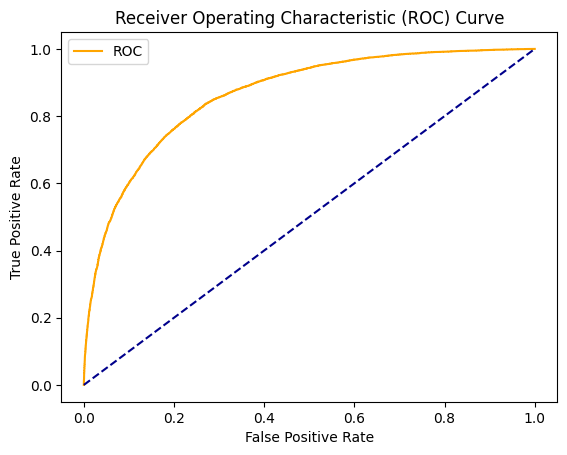

Accuracy = 0.8659118149593247
ROC Area under Curve = 0.8638199133935296
Cohen's Kappa = 0.7206899319750827
Time taken = 0.8388516902923584
              precision    recall  f1-score   support

         0.0    0.90392   0.87327   0.88833     23948
         1.0    0.81122   0.85437   0.83224     15265

    accuracy                        0.86591     39213
   macro avg    0.85757   0.86382   0.86028     39213
weighted avg    0.86783   0.86591   0.86649     39213



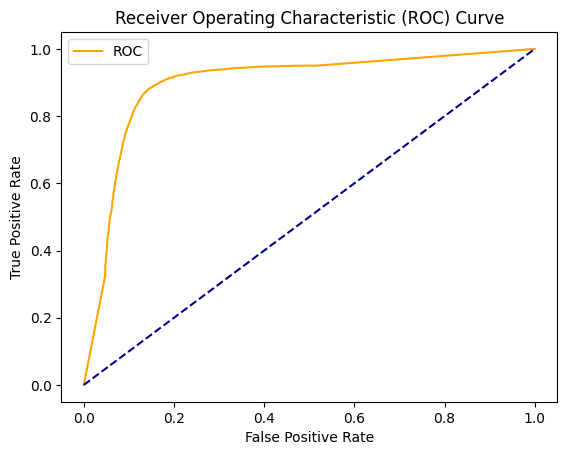

Accuracy = 0.8860836967332262
ROC Area under Curve = 0.8812849502341874
Cohen's Kappa = 0.7609342163563244
Time taken = 577.4239780902863
              precision    recall  f1-score   support

         0.0    0.90983   0.90296   0.90638     23948
         1.0    0.84954   0.85961   0.85455     15265

    accuracy                        0.88608     39213
   macro avg    0.87969   0.88128   0.88046     39213
weighted avg    0.88636   0.88608   0.88620     39213



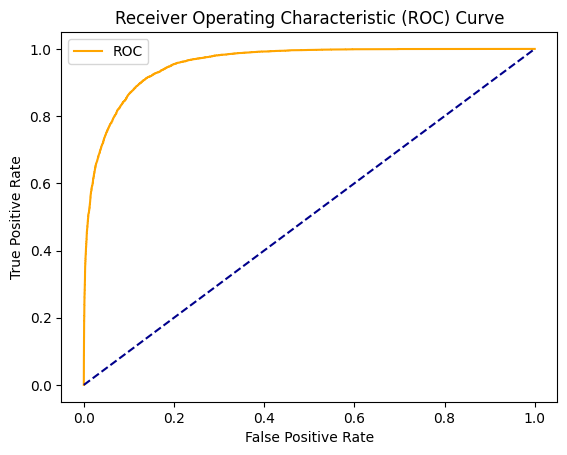

Accuracy = 0.9280595720806876
ROC Area under Curve = 0.9265770863620824
Cohen's Kappa = 0.8493714659078331
Time taken = 42.80492830276489
              precision    recall  f1-score   support

         0.0    0.94812   0.93327   0.94064     23948
         1.0    0.89783   0.91988   0.90872     15265

    accuracy                        0.92806     39213
   macro avg    0.92297   0.92658   0.92468     39213
weighted avg    0.92854   0.92806   0.92821     39213



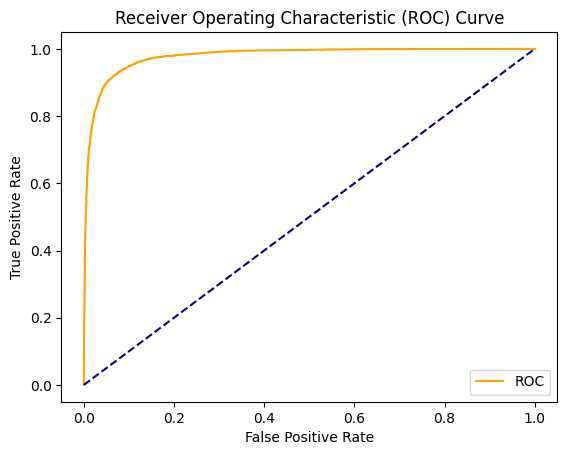

[LightGBM] [Info] Number of positive: 45912, number of negative: 71727
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015451 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4308
[LightGBM] [Info] Number of data points in the train set: 117639, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.390279 -> initscore=-0.446141
[LightGBM] [Info] Start training from score -0.446141
Accuracy = 0.8684619896462907
ROC Area under Curve = 0.860694163700355
Cohen's Kappa = 0.7228133047900757
Time taken = 4.905483245849609
              precision    recall  f1-score   support

         0.0    0.88961   0.89577   0.89268     23948
         1.0    0.83469   0.82561   0.83013     15265

    accuracy                        0.86846     39213
   macro avg    0.86215   0.86069   0.86140     39213
weighted avg    0.86823   0.86846   0.86833     39213



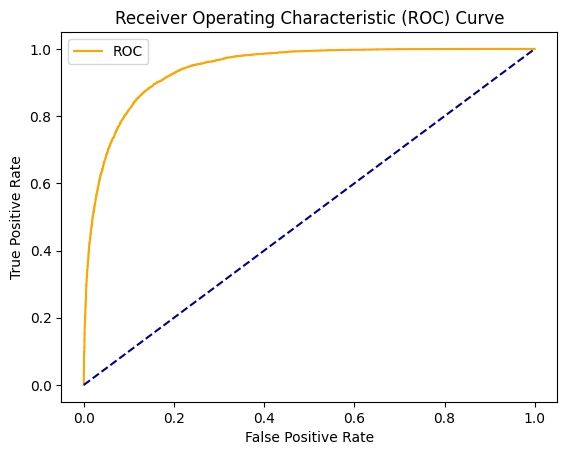

Accuracy = 0.9418560171371739
ROC Area under Curve = 0.9449267946584342
Cohen's Kappa = 0.8791826232502136
Time taken = 458.76479053497314
              precision    recall  f1-score   support

         0.0    0.97256   0.93106   0.95136     23948
         1.0    0.89863   0.95879   0.92774     15265

    accuracy                        0.94186     39213
   macro avg    0.93560   0.94493   0.93955     39213
weighted avg    0.94378   0.94186   0.94216     39213



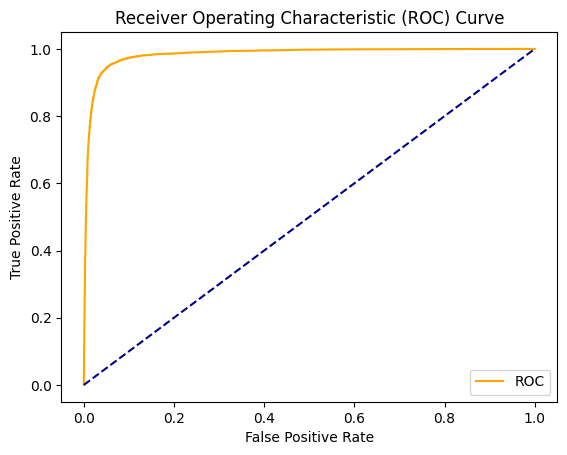

Accuracy = 0.9563665111060108
ROC Area under Curve = 0.9565810552736519
Cohen's Kappa = 0.908683590430594
Time taken = 292.1470592021942
              precision    recall  f1-score   support

         0.0    0.97246   0.95561   0.96396     23948
         1.0    0.93221   0.95755   0.94471     15265

    accuracy                        0.95637     39213
   macro avg    0.95234   0.95658   0.95434     39213
weighted avg    0.95679   0.95637   0.95647     39213



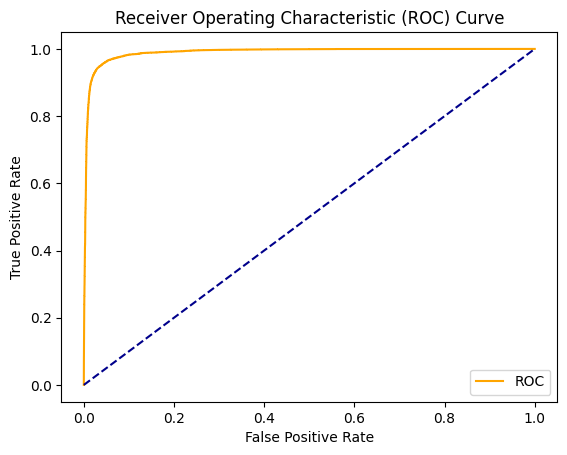

In [23]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression

params_lr = {'penalty': 'l1', 'solver':'liblinear'}

model_lr = LogisticRegression(**params_lr)
model_lr, accuracy_lr, roc_auc_lr, coh_kap_lr, tt_lr = run_model(model_lr, X_train, y_train, X_test, y_test)

# Decision Tree
from sklearn.tree import DecisionTreeClassifier

params_dt = {'max_depth': 16,
             'max_features': "sqrt"}

model_dt = DecisionTreeClassifier(**params_dt)
model_dt, accuracy_dt, roc_auc_dt, coh_kap_dt, tt_dt = run_model(model_dt, X_train, y_train, X_test, y_test)

# Neural Network
from sklearn.neural_network import MLPClassifier

params_nn = {'hidden_layer_sizes': (30,30,30),
             'activation': 'logistic',
             'solver': 'lbfgs',
             'max_iter': 500}

model_nn = MLPClassifier(**params_nn)
model_nn, accuracy_nn, roc_auc_nn, coh_kap_nn, tt_nn = run_model(model_nn, X_train, y_train, X_test, y_test)

# Random Forest
from sklearn.ensemble import RandomForestClassifier

params_rf = {'max_depth': 16,
             'min_samples_leaf': 1,
             'min_samples_split': 2,
             'n_estimators': 100,
             'random_state': 12345}

model_rf = RandomForestClassifier(**params_rf)
model_rf, accuracy_rf, roc_auc_rf, coh_kap_rf, tt_rf = run_model(model_rf, X_train, y_train, X_test, y_test)

# Light GBM
import lightgbm as lgb
params_lgb ={'colsample_bytree': 0.95, 
         'max_depth': 16, 
         'min_split_gain': 0.1, 
         'n_estimators': 200, 
         'num_leaves': 50, 
         'reg_alpha': 1.2, 
         'reg_lambda': 1.2, 
         'subsample': 0.95, 
         'subsample_freq': 20}

model_lgb = lgb.LGBMClassifier(**params_lgb)
model_lgb, accuracy_lgb, roc_auc_lgb, coh_kap_lgb, tt_lgb = run_model(model_lgb, X_train, y_train, X_test, y_test)

# Catboost
import catboost as cb
params_cb ={'iterations': 50,
            'max_depth': 16}

model_cb = cb.CatBoostClassifier(**params_cb)
model_cb, accuracy_cb, roc_auc_cb, coh_kap_cb, tt_cb = run_model(model_cb, X_train, y_train, X_test, y_test, verbose=False)

# XGBoost
import xgboost as xgb
params_xgb ={'n_estimators': 500,
            'max_depth': 16}

model_xgb = xgb.XGBClassifier(**params_xgb)
model_xgb, accuracy_xgb, roc_auc_xgb, coh_kap_xgb, tt_xgb = run_model(model_xgb, X_train, y_train, X_test, y_test)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005734 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003319 seconds.
You can set `force_col_wise=true` to remove the overhead.


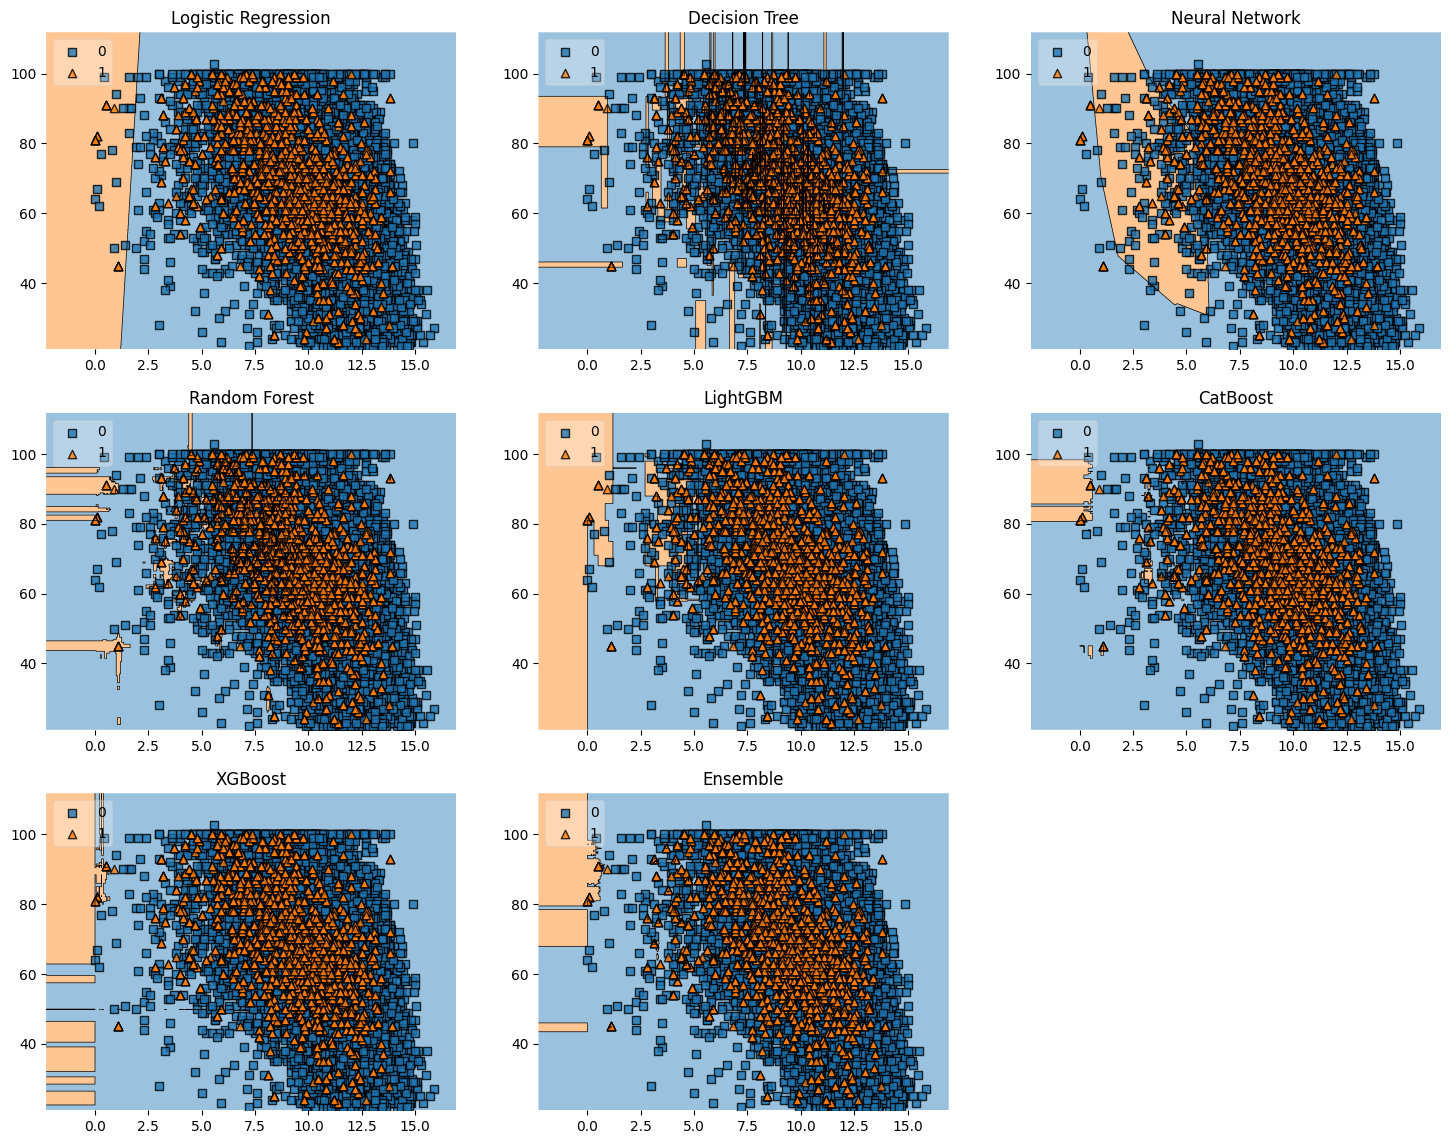

In [25]:
from mlxtend.classifier import EnsembleVoteClassifier
from mlxtend.plotting import plot_decision_regions

value = 1.80
width = 0.90

clf1 = LogisticRegression(random_state=12345)
clf2 = DecisionTreeClassifier(random_state=12345) 
clf3 = MLPClassifier(random_state=12345, verbose = 0)
clf4 = RandomForestClassifier(random_state=12345)
clf5 = lgb.LGBMClassifier(random_state=12345, verbose = 0)
clf6 = cb.CatBoostClassifier(random_state=12345, verbose = 0)
clf7 = xgb.XGBClassifier(random_state=12345)
eclf = EnsembleVoteClassifier(clfs=[clf4, clf5, clf6, clf7], weights=[1, 1, 1, 1], voting='soft')

X_list = MiceImputed[["Sunshine", "Humidity9am", "Cloud3pm"]] #took only really important features
X = np.asarray(X_list, dtype=np.float32)
y_list = MiceImputed["RainTomorrow"]
y = np.asarray(y_list, dtype=np.int32)

# Plotting Decision Regions
gs = gridspec.GridSpec(3,3)
fig = plt.figure(figsize=(18, 14))

labels = ['Logistic Regression',
          'Decision Tree',
          'Neural Network',
          'Random Forest',
          'LightGBM',
          'CatBoost',
          'XGBoost',
          'Ensemble']

for clf, lab, grd in zip([clf1, clf2, clf3, clf4, clf5, clf6, clf7, eclf],
                         labels,
                         itertools.product([0, 1, 2],
                         repeat=2)):
    clf.fit(X, y)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X, y=y, clf=clf, 
                                filler_feature_values={2: value}, 
                                filler_feature_ranges={2: width}, 
                                legend=2)
    plt.title(lab)

plt.show()